# LeNet复现实验

## 实验目的
试选用一个深度学习框架，利用MNIST数据集训练一个LeNet模型，并统计平均识别准确率

## 实验环境
PyTorch 2.4.0
CUDA 12.4

## 实验方法

### 选择深度学习框架
选择PyTorch作为本次实验的深度学习框架，主要是因为它提供了动态计算图的支持，这使得代码调试更加直观且易于理解。PyTorch拥有强大的社区支持和丰富的资源，这对于解决开发过程中遇到的问题非常有帮助。此外，PyTorch与CUDA的集成非常紧密，能够充分利用GPU加速计算，这对于拥有如3060 Laptop GPU这样支持CUDA操作的显卡的设备来说，意味着可以显著提升训练速度和效率。

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from PIL import Image

### MNIST数据集
MNIST 数据集是一个非常著名的手写数字识别数据集，它常被用来作为机器学习和计算机视觉领域中的基准测试数据。MNIST（Modified National Institute of Standards and Technology）数据集包含60000个训练样本和10000个测试样本，每个样本都是一个28x28像素大小的灰度图像，代表了0到9之间的某个数字。`torchvision`的`datasets`内置了加载MNIST的功能，可以用`datasets.MNIST`下载、加载和预处理。在预处理中，用`transforms`将其归一化到0-1之间，并转换为张量。

数据集应该被划分为训练集、验证集、测试集三个部分。其中测试集仅用于测试模型性能，不应该参与训练，就用MNIST提供的测试集；训练集用于模型训练；验证集用于在训练时验证模型效果，调整超参，可以从MNIST训练集中抽取一部分，这里用`torch.utils.data`中的`random_split`函数分割，比例选取为8:2。

In [15]:
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms

# Pre-processing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.05,), (0.5,))
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split train dataset into train and validation
train_ratio = 0.8
train_size = int(train_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### LeNet
LeNet 是一个经典的卷积神经网络，其中LeNet-5由Yann LeCun等人在1998年的论文《Gradient-Based Learning Applied to Document Recognition》中提出。这个网络架构主要用于手写字符识别，特别是在识别邮政编码和银行支票上的数字方面取得了成功。根据LeNet-5的原始论文，其结构如下所述。

#### C1
第一层（C1）是一个包含6个5x5卷积核的卷积层，用以提取图像中的基本特征。输入层接收的是32x32像素的图像。这意味着C1的padding=2：

#### S2
第二层(S2)原文是：
```
The four inputs to a unit in S2 are added, then multiplied by a trainable coefficient, and then added to a trainable bias. The result is passed through a sigmoidal function.
```
这相当于先经过2x2的平均池化层，然后通过一层激活函数：
$$y^{(2)}=\sigma(wa^{(2)}+b)$$

In [16]:
class LeNetSampling(nn.Module):
    def __init__(self, out_channels, kernel_size):
        super(LeNetSampling, self).__init__()
        self.kernel_size = kernel_size
        self.weights = nn.Parameter(torch.Tensor(1, out_channels, 1, 1))
        self.bias = nn.Parameter(torch.Tensor(1, out_channels, 1, 1))
        self.reset_parameters()
    
    def forward(self, x):
        x = F.avg_pool2d(x, self.kernel_size)
        x = x*self.weights + self.bias
        return x
    
    def reset_parameters(self):
        self.weights = nn.init.kaiming_uniform_(self.weights, a=math.sqrt(1))
        self.bias.data.fill_(0.01)

但是现在我们知道在池化层后加线性函数的做法意义不大，所以我们改用单纯的池化层。

#### C3
第三层（C3）是一个包含16个5x5卷积核的卷积层。值得注意的是每个卷积核与S2的6个特征图特征图并非都是全部连接的。具体来说：
- 前六个C3特征图从S2层的每三个连续特征图中获取输入。
- 接下来的六个C3特征图从S2层的每四个连续特征图中获取输入。
- 再接下来的三个C3特征图从S2层的一些不连续的四个特征图中获取输入。
- 最后一个C3特征图从所有的S2特征图中获取输入。
卷积核对每个相连的特征图分通道卷积，然后将所有通道按元素相加，最终输出16个10x10的特征图。

这需要我们定义新的神经网络层继承自`nn.Module`。但是由于我们现在算力充足，我们可以简化为每个卷积核对6个特征图全连接。

#### S4
第四层（S4）再次执行与S2相似的子采样，等价于2x2的平均池化层再通过激活函数层，进一步压缩空间信息，输出16个5x5特征图。

#### C5
第五层（C5）是一个包含120个5x5卷积核的卷积层，每个卷积核和S4的16个特征图全有连接，输出120个1x1特征图，相当于一个120维向量。

#### F6
第六层（F6）是一个宽度84的全连接层，其激活函数为：
$$f(a)=A\tanh(Sa)$$
其中作者取$A=1.7159, S=0.6667$以满足$f(1)=1,f(-1)=-1$

In [17]:
class Tanh(nn.Module):
    def forward(self, x):
        return 1.7159*torch.tanh(x*2/3)

但我们这里用后来发现更快捷的ReLU作为激活函数。

#### OUTPUT
输出层（OUTPUT）是一个宽度10的径向激活函数（RBF）全连接层：
$$\phi_i(y^{(6)})=\exp(-\frac{\sum_{j}\|y_j^{(6)}-w_{ij}\|^2}{\sigma_i^2})$$
其权重$w_{ij}$是人工设计且不加入训练的。权重提取自0到9的字符图像，拉平后正好84维，和最后特征图的维数匹配：

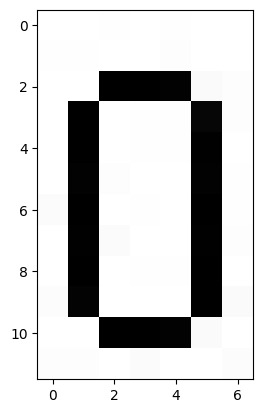

In [18]:
import os
import matplotlib.pyplot as plt

file = os.path.join('data', 'RBF', f'0_RBF.jpg')
img = Image.open(file).convert('L')
plt.imshow(img, cmap='gray')

0对应的权重如图所示。

RBF层可以设计为：

In [19]:
class RBF(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(RBF, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.load_params()

    def forward(self, x):
        size = (x.size(0), self.out_channels, self.in_channels)
        x = x.unsqueeze(1).expand(size)
        c = self.kernels.expand(size)
        output = (x - c).pow(2).sum(-1)
        return output
     
    def load_params(self):
        kernels = []
        for i in range(self.out_channels):
            file = os.path.join('data', 'RBF', f'{i}_RBF.jpg')
            image = Image.open(file).convert('L')
            image = transform(image)
            image = torch.where(image > 0.5, torch.tensor(1.0), torch.tensor(0.0))
            kernels.append(image.flatten())
        self.kernels = torch.stack(kernels, dim=0).to(self.device)

但是RBF在后来渐渐已经不再使用，所以我们改用简单的一层全连接，加上后来广泛使用的（对数）Softmax激活函数。并且，我们将层间激活函数都改为运算快捷的ReLU。

综上，根据原文改进后的LeNet的结构可以表示为：

In [20]:
class MyLeNet(nn.Module):
    def __init__(self):
        super(MyLeNet, self).__init__()
        # C1 Convolution Layer
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)  # Input channels=1 for grayscale, output channels=6, kernel size=5x5
        # S2 Subsampling Layer (Pooling)
        self.pool1 = nn.AvgPool2d(2, 2)  # 2x2 average pooling
        # C3 Convolution Layer
        self.conv2 = nn.Conv2d(6, 16, 5)  # Input channels=6 from C1, output channels=16, kernel size=5x5
        # S4 Subsampling Layer
        self.pool2 = nn.AvgPool2d(2, 2)
        # C5 Convolution Layer
        self.conv3 = nn.Conv2d(16, 120, 5)  # Input channels=16 from S4, output channels=120, kernel size=5x5
        # F6 Fully Connected Layer
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = x.view(-1, 120)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

### 训练
训练时原论文使用的损失函数为：
$$E(W)=\frac{1}{P}\sum_{p=1}^P\left(y_{D^p}(Z^p,W)+\log(e^{-j}+\sum_i{e^{-y_i(Z^p,W)}})\right)$$
大概就是MSE加上一个正则化项

In [21]:
def loss_fn(output, target):
    loss = output[target==1].pow(2).sum()
    loss += torch.log(torch.exp(torch.tensor(0.1))+torch.exp(-output[target==0]).sum())
    return loss

但是这太麻烦了，对于Softmax激活函数输出，我们知道交叉熵损失是很合适的。

In [22]:
criterion = nn.CrossEntropyLoss()

然后定义一个用于训练并记录信息的函数。

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

def train_model(model, train_dataset, val_dataset, 
                criterion=nn.MSELoss(), 
                optimizer=optim.Adam,
                epochs=10, 
                batch_size=32, 
                learning_rate=0.001, 
                device=torch.device('cpu'), 
                log_dir="log"):
    # model
    model.to(device)
    
    # dataset
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # optimizer
    optimizer = optimizer(model.parameters(), lr=learning_rate)

    # TensorBoard writer
    writer = SummaryWriter(log_dir)
    
    global_step = 0

    for epoch in range(epochs):
        model.train()

        for i, (inputs, labels) in enumerate(train_loader):
            # Move data to device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Statistics
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            
            train_loss = loss.item()
            train_acc = 100 * correct / labels.size(0)
            writer.add_scalar('Loss/train', train_loss, global_step)
            writer.add_scalar('Accuracy/train', train_acc, global_step)
            
            global_step += 1

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total

        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/val', val_acc, epoch)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}')

    writer.close()

开始训练

In [24]:
model = MyLeNet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_model(model, train_dataset, val_dataset, 
            criterion=criterion, 
            optimizer=optim.Adam, 
            epochs=10, 
            batch_size=64, 
            learning_rate=0.001, 
            device=device,
            log_dir="logs/MyLeNet")

Epoch [1/10], Train Loss: 0.1034, Train Acc: 96.88, Val Loss: 0.1400, Val Acc: 95.41
Epoch [2/10], Train Loss: 0.0188, Train Acc: 100.00, Val Loss: 0.0732, Val Acc: 97.65
Epoch [3/10], Train Loss: 0.0352, Train Acc: 98.44, Val Loss: 0.0493, Val Acc: 98.42
Epoch [4/10], Train Loss: 0.0248, Train Acc: 98.44, Val Loss: 0.0463, Val Acc: 98.57
Epoch [5/10], Train Loss: 0.0502, Train Acc: 98.44, Val Loss: 0.0458, Val Acc: 98.52
Epoch [6/10], Train Loss: 0.0090, Train Acc: 100.00, Val Loss: 0.0410, Val Acc: 98.75
Epoch [7/10], Train Loss: 0.0376, Train Acc: 96.88, Val Loss: 0.0402, Val Acc: 98.83
Epoch [8/10], Train Loss: 0.0453, Train Acc: 96.88, Val Loss: 0.0395, Val Acc: 98.71
Epoch [9/10], Train Loss: 0.0487, Train Acc: 96.88, Val Loss: 0.0427, Val Acc: 98.56
Epoch [10/10], Train Loss: 0.0020, Train Acc: 100.00, Val Loss: 0.0396, Val Acc: 98.88


显示loss和accu曲线

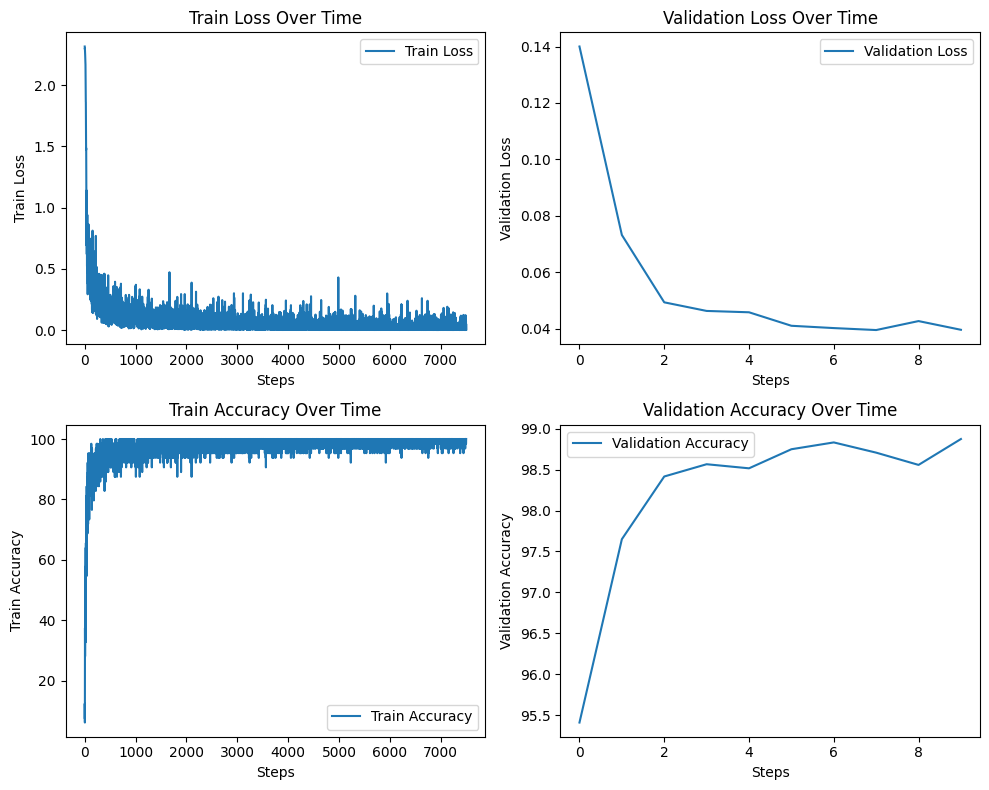

In [25]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def extract_tensorboard_data(log_dir, scalar_name):
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()

    scalar_values = event_acc.Scalars(scalar_name)
    
    values = [x.value for x in scalar_values]

    return values

def plot_tensorboard_log_subplots(log_dir):
    scalars = {
        'Loss/train': 'Train Loss',
        'Loss/val': 'Validation Loss',
        'Accuracy/train': 'Train Accuracy',
        'Accuracy/val': 'Validation Accuracy'
    }

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    for i, (scalar_name, label) in enumerate(scalars.items()):
        values = extract_tensorboard_data(log_dir, scalar_name)
        indices = range(len(values))
        ax = axes[i // 2, i % 2]
        ax.plot(indices, values, label=label)
        ax.set_xlabel('Steps')
        ax.set_ylabel(label)
        ax.set_title(f'{label} Over Time')
        ax.legend()
    plt.tight_layout()
    plt.show()

log_dir = 'logs/MyLeNet/events.out.tfevents.1725724346.SunnyYYsLaptop.126792.0'

plot_tensorboard_log_subplots(log_dir)

可以看到，loss和accu的形状都很正常，说明模型按照预期收敛；而train和valid的值差异不是太大，说明没有发生明显的过拟合。

保存训练好的模型参数

In [26]:
import datetime
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
torch.save(model.state_dict(), os.path.join("models", f"model_{current_time}.pth"))

### 测试模型效果
编写测试函数

In [27]:
def test_model(model, test_dataset, 
               criterion=nn.MSELoss(), 
               batch_size=32,
               device=torch.device('cpu')):
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    model.to(device)
    model.eval()

    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total

    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    return avg_test_loss, test_accuracy

测试模型

In [28]:
model = MyLeNet()
model.load_state_dict(torch.load(os.path.join("models", "model_2024-09-07_23-56-41.pth"), weights_only=True))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss, acc = test_model(model, test_dataset, criterion=criterion, batch_size=64, device=device)

Test Loss: 0.0384, Test Accuracy: 98.77%


模型准确率达到98.77%，效果很不错。